In [2]:
import tensorflow as tf
import numpy as np
import math
import os
import random
import numpy as np
import pandas as pd
from pandas import DataFrame
import math
import copy
import pickle

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
train = pd.read_csv('../../data/train_scaled_encoded.csv')
train.head()

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,vaso_input,iv_input,reward,icustayid
0,0.029027,0.061212,0.224086,0.079448,0.052524,0.077151,0.103817,0.063714,0.032102,0.042459,...,0.083823,0.053838,0.081020,0.057297,0.030372,0.047363,0,0.0,0.0,12.0
1,0.031518,0.078677,0.120369,0.040228,0.047623,0.104624,0.093498,0.073046,0.035958,0.056553,...,0.088714,0.073047,0.083202,0.043883,0.036930,0.057726,0,0.0,0.0,12.0
2,0.030942,0.083416,0.106333,0.040481,0.039120,0.098819,0.077658,0.074696,0.041053,0.053553,...,0.092754,0.079161,0.082560,0.041910,0.036587,0.067986,0,0.0,0.0,12.0
3,0.042970,0.050963,0.090261,0.093201,0.031332,0.057674,0.032040,0.054802,0.061447,0.053960,...,0.098049,0.074196,0.088113,0.045784,0.041096,0.129189,0,0.0,15.0,12.0
4,0.064572,0.084793,0.065976,0.070753,0.063990,0.051591,0.050112,0.049624,0.092619,0.080058,...,0.032011,0.081824,0.037519,0.061251,0.071471,0.039540,0,4.0,0.0,14.0


In [5]:
test = pd.read_csv('../../data/test_scaled_encoded.csv')
test.head()

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,vaso_input,iv_input,reward,icustayid
0,0.044787,0.024944,0.059501,0.186372,0.099174,0.010116,0.015910,0.031792,0.063170,0.050696,...,0.037952,0.041529,0.046699,0.054380,0.082892,0.012378,0,4.0,0.0,61.0
1,0.048257,0.029508,0.033046,0.102542,0.107019,0.015018,0.014971,0.034197,0.057205,0.072662,...,0.037210,0.051388,0.044145,0.039312,0.096143,0.013473,0,4.0,0.0,61.0
2,0.041906,0.028968,0.028705,0.111719,0.098205,0.013579,0.012648,0.027884,0.074506,0.081935,...,0.037256,0.055131,0.042269,0.039004,0.103266,0.015244,0,4.0,0.0,61.0
3,0.040383,0.029019,0.029167,0.131740,0.099840,0.013389,0.012455,0.028260,0.072425,0.088626,...,0.037022,0.057600,0.039294,0.038362,0.117384,0.015660,0,4.0,0.0,61.0
4,0.045685,0.029040,0.027817,0.137894,0.106901,0.013968,0.012697,0.028393,0.073113,0.088150,...,0.036816,0.058196,0.038383,0.038041,0.123431,0.014925,0,4.0,0.0,61.0


In [6]:
REWARD_THRESHOLD =15
reg_lambda = 5

In [7]:
# PER important weights and params
per_flag = True
beta_start = 0.9
train['prob'] = abs(train['reward'])
temp = 1.0 / train['prob']
temp[temp == float('Inf')] = 1.0
train['imp_weight'] = pow((1.0 / len(train) * temp), beta_start)

In [9]:
train.loc[train['icustayid'] == 14]

,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,vaso_input,iv_input,reward,icustayid,prob,imp_weight
4,0.064572,0.084793,0.065976,0.070753,0.063990,0.051591,0.050112,0.049624,0.092619,0.080058,...,0.037519,0.061251,0.071471,0.039540,0,4.0,0.0,14.0,0.0,0.000022
5,0.074025,0.079019,0.069797,0.068576,0.069831,0.043737,0.056884,0.073837,0.073740,0.075134,...,0.040486,0.053812,0.067138,0.043424,0,3.0,0.0,14.0,0.0,0.000022
6,0.067640,0.073252,0.077615,0.072775,0.074835,0.040598,0.054152,0.078552,0.073434,0.086740,...,0.043017,0.054578,0.068782,0.045069,0,3.0,0.0,14.0,0.0,0.000022
7,0.084182,0.069916,0.070347,0.069123,0.072279,0.034510,0.053141,0.090075,0.061658,0.072907,...,0.049218,0.054276,0.064720,0.051236,0,2.0,0.0,14.0,0.0,0.000022
8,0.113805,0.048466,0.068828,0.080646,0.059614,0.016070,0.028201,0.081736,0.072616,0.049215,...,0.051598,0.057034,0.067416,0.083398,0,0.0,0.0,14.0,0.0,0.000022
9,0.103441,0.079006,0.073327,0.083135,0.065522,0.030426,0.026677,0.059899,0.066019,0.055480,...,0.065361,0.069394,0.072032,0.120818,0,0.0,0.0,14.0,0.0,0.000022
10,0.101310,0.064388,0.070295,0.103702,0.062022,0.026225,0.029238,0.069330,0.088385,0.064827,...,0.063749,0.072680,0.077492,0.109648,0,2.0,0.0,14.0,0.0,0.000022
11,0.089622,0.053569,0.067050,0.118848,0.064748,0.025035,0.034923,0.078645,0.086481,0.075960,...,0.063923,0.076082,0.078420,0.104181,0,2.0,0.0,14.0,0.0,0.000022
12,0.094056,0.052298,0.068664,0.119672,0.071022,0.029564,0.037301,0.062040,0.070939,0.079584,...,0.052991,0.083214,0.070643,0.099471,0,2.0,0.0,14.0,0.0,0.000022
13,0.093668,0.047470,0.073948,0.109111,0.074271,0.028844,0.038724,0.067044,0.064909,0.077116,...,0.048472,0.077113,0.064924,0.103841,0,2.0,15.0,14.0,15.0,0.000002


In [211]:
hidden_1_size = 128
hidden_2_size = 128

class Qnetwork():
    def __init__(self):
        
        self.phase = tf.placeholder(tf.bool)
        self.num_actions = 25
        self.input_size = 200
        self.state = tf.placeholder(tf.float32, shape=[None, self.input_size],name="input_state")
        
        self.fc_1 = tf.contrib.layers.fully_connected(self.state, hidden_1_size, activation_fn=None)
        self.fc_1_bn = tf.contrib.layers.batch_norm(self.fc_1, center=True, scale=True, is_training=self.phase)
        self.fc_1_ac = tf.maximum(self.fc_1_bn, self.fc_1_bn * 0.5)
        
        self.fc_2 = tf.contrib.layers.fully_connected(self.fc_1_ac, hidden_2_size, activation_fn=None)
        self.fc_2_bn = tf.contrib.layers.batch_norm(self.fc_2, center=True, scale=True, is_training=self.phase)
        self.fc_2_ac = tf.maximum(self.fc_2_bn, self.fc_2_bn * 0.5)
        
        # advantage and value streams
        self.streamA, self.streamV = tf.split(self.fc_2_ac,2,axis=1)
        self.Advantage = tf.contrib.layers.fully_connected(self.streamA, self.num_actions, activation_fn=None)
        self.Value = tf.contrib.layers.fully_connected(self.streamV, 1, activation_fn=None)
#         self.AW = tf.Variable(tf.random_normal([hidden_2_size//2, self.num_actions], stddev=0.3))
#         self.VW = tf.Variable(tf.random_normal([hidden_2_size//2, 1], stddev=0.3))
#         self.Advantage = tf.matmul(self.streamA, self.AW)
#         self.Value = tf.matmul(self.streamV, self.VW)
        
        # Then combine them together to get our final Q-values.
        self.q_output = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.q_output, 1, name='predict') # vector of length batch size
        
        #Below we obtain the loss by taking the sum of squares difference between the target and predicted Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, self.num_actions,dtype=tf.float32)
        
        # Importance sampling weights for PER, used in network update    
        self.imp_weights = tf.placeholder(shape=[None], dtype=tf.float32)
        # select the Q values for the actions that would be selected
        self.Q = tf.reduce_sum(tf.multiply(self.q_output, self.actions_onehot), reduction_indices=1) # batch size x 1 vector
        
        # reward threshold, to ensure reasonable Q-value predictions  
        self.reg_vector = tf.maximum(tf.abs(self.Q)-REWARD_THRESHOLD,0)
        self.reg_term = tf.reduce_sum(self.reg_vector)
        
        self.abs_error = tf.abs(self.targetQ - self.Q)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        
        # below is the loss when we are not using PER
        self.old_loss = tf.reduce_mean(self.td_error)
        
        # as in the paper, to get PER loss we weight the squared error by the importance weights
        self.per_error = tf.multiply(self.td_error, self.imp_weights)

        # total loss is a sum of PER loss and the regularisation term
        if per_flag:
            self.loss = tf.reduce_mean(self.per_error) + reg_lambda * self.reg_term
        else:
            self.loss = self.old_loss + reg_lambda * self.reg_term

        self.trainer = tf.train.AdamOptimizer(learning_rate=0.00005)
        self.update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(self.update_ops):
        # Ensures that we execute the update_ops before performing the model update, so batchnorm works
            self.update_model = self.trainer.minimize(self.loss)

In [165]:
# function is needed to update parameters between main and target network
# tf_vars are the trainable variables to update, and tau is the rate at which to update
# returns tf ops corresponding to the updates
def update_target_graph(tf_vars,tau):
    total_vars = len(tf_vars)
    op_holder = []
    for idx,var in enumerate(tf_vars[0:int(total_vars/2)]):
        op_holder.append(tf_vars[idx+int(total_vars/2)].assign((var.value()*tau) + ((1-tau)*tf_vars[idx+int(total_vars/2)].value())))
    return op_holder

In [166]:
def update_target(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [167]:
# define an action mapping - how to get an id representing the action from the (iv,vaso) tuple
action_map = {}
count = 0
for iv in range(5):
    for vaso in range(5):
        action_map[(iv, vaso)] = count
        count += 1

In [168]:
# generates batches for the Q network - depending on train and eval_type, can select data from train/val/test sets.
def process_batch(size, train_phase=True, eval_type = None):
    
    if not train_phase:
        
        if eval_type is None:
            raise Exception('Provide eval_type to process_batch')
        elif eval_type == 'train':
            a = train.copy()
        elif eval_type == 'val':
            a = val_df.copy()
        elif eval_type == 'test':
            a = test.copy()
        else:
            raise Exception('Unknown eval_type')
    else:
        if per_flag:
            # uses prioritised exp replay
            a = train.sample(n=size, weights=train['prob'])
        else:
            a = train.sample(n=size)
            
    if size == None:
        size = len(a)
    
    states = np.zeros((size, 200))
    actions = np.zeros((size, 1), dtype=int)
    rewards = np.zeros((size, 1))
    next_states = np.zeros((size, 200))
    done_flags = np.zeros((size, 1))
    
    counter = 0
    for idx, obser in a.iterrows():
        cur_state = obser[:200]
        iv = int(obser.loc['iv_input'])
        vaso = int(obser.loc['vaso_input'])
        action = action_map[iv, vaso]
        reward = obser.loc['reward']
        
        if idx != train.index[-1]:
            # if not terminal step in trajectory             
            if train.loc[idx, 'icustayid'] == train.loc[idx + 1, 'icustayid']:
                next_state = train.iloc[idx + 1, :200]
                done = 0
            else:
                # trajectory is finished
                next_state = np.zeros(len(cur_state))
                done = 1
        else:
            # last entry in df is the final state of that trajectory
            next_state = np.zeros(len(cur_state))
            done = 1
        
        states[counter] = cur_state
        actions[counter] = action
        rewards[counter] = reward
        next_states[counter] = next_state
        done_flags[counter] = done
        counter += 1
        
    return (states, np.squeeze(actions), np.squeeze(rewards), next_states, np.squeeze(done_flags), a)

In [169]:
#  Used to run diagnostics on the train set
phys_q_train = []
agent_q_train = []
phys_actions_tr = []
agent_actions_tr = []

def train_set_performance():
    count = 0
    global phys_q_train
    global agent_q_train
    global phys_actions
    global agent_actions
    phys_q_train = []
    agent_q_train = []
    phys_actions_tr = []
    agent_actions_tr = []
    for r in train.index:
        cur_state = [train.iloc[r, :200]]
        iv = int(train.loc[r, 'iv_input'])
        vaso = int(train.loc[r, 'vaso_input'])
        action = action_map[iv, vaso]
        output_q = np.squeeze(sess.run(mainQN.q_output, feed_dict = {mainQN.state : cur_state, mainQN.phase : False}))
        phys_q_train.append(output_q[action])
        agent_q_train.append(max(output_q))
        agent_actions_tr.append(np.argmax(output_q))
        phys_actions_tr.append(action)
        count += 1

In [170]:
def do_eval(eval_type):
    states,actions,rewards,next_states,done_flags, _ = process_batch(size=None,train_phase=False,eval_type=eval_type)
    # firstly get the chosen actions at the next timestep
    actions_from_q1 = sess.run(mainQN.predict,feed_dict={mainQN.state: next_states, mainQN.phase : 0})

    # Q values for the next timestep from target network, as part of the Double DQN update
    Q2 = sess.run(targetQN.q_output,feed_dict={targetQN.state:next_states, targetQN.phase : 0})
    # handles the case when a trajectory is finished
    end_multiplier = 1 - done_flags

    # target Q value using Q values from target, and actions from main
    double_q_value = Q2[range(len(actions_from_q1)), actions_from_q1]

    # definition of target Q
    targetQ = rewards + ( gamma * double_q_value * end_multiplier )

    # get the output q's, actions, and loss
    q_output, actions_taken, abs_err = sess.run([mainQN.q_output, mainQN.predict, mainQN.abs_error], \
        feed_dict={mainQN.state:states,
                   mainQN.targetQ:targetQ, 
                   mainQN.actions:actions,
                   mainQN.phase:False})
    # return the relevant q values and actions
    phys_q = q_output[range(len(q_output)), actions]
    agent_q = q_output[range(len(q_output)), actions_taken]
    error = np.mean(abs_err)
    
    return phys_q, actions, agent_q, actions_taken, error

In [171]:
def do_save_results():
    
    # get the chosen actions for the train, val, and test set when training is complete.
    phys_q_train, actions_train, agent_q_train, agent_actions_train, _ = do_eval(eval_type = 'train')        
    # phys_q_val, actions_val, agent_q_val, agent_actions_val, _ = do_eval(eval_type = 'val')        
    phys_q_test, actions_test, agent_q_test, agent_actions_test, _ = do_eval(eval_type = 'test')  
    
    # save everything for later - they're used in policy evaluation and when generating plots
    
    ## Physician q
    with open(save_dir + 'dqn_autoencode_phy_q_train.p', 'wb') as f:
        pickle.dump(phys_q_train, f)
#     with open(save_dir + 'dqn_autoencode_phy_q_val.p', 'wb') as f:
#         pickle.dump(phys_q_val, f)
    with open(save_dir + 'dqn_autoencode_phy_q_test.p', 'wb') as f:
        pickle.dump(phys_q_test, f)
    
    ## Physician action
    with open(save_dir + 'dqn_autoencode_phy_actions_train.p', 'wb') as f:
        pickle.dump(actions_train, f)
#     with open(save_dir + 'dqn_autoencode_phy_actions_val.p', 'wb') as f:
#         pickle.dump(actions_val, f)
    with open(save_dir + 'dqn_autoencode_phy_actions_test.p', 'wb') as f:
        pickle.dump(actions_test, f)
    
    ## Agent actions
    with open(save_dir + 'dqn_autoencode_agent_actions_train.p', 'wb') as f:
        pickle.dump(agent_actions_train, f)
#     with open(save_dir + 'dqn_autoencode_actions_val.p', 'wb') as f:
#         pickle.dump(agent_actions_val, f)
    with open(save_dir + 'dqn_autoencode_agent_actions_test.p', 'wb') as f:
        pickle.dump(agent_actions_test, f)
    
    ## Agent Q
    with open(save_dir + 'dqn_autoencode_agent_q_train.p', 'wb') as f:
        pickle.dump(agent_q_train, f)
#     with open(save_dir + 'dqn_autoencode_q_val.p', 'wb') as f:
#         pickle.dump(agent_q_val, f)
    with open(save_dir + 'dqn_autoencode_agent_q_test.p', 'wb') as f:
        pickle.dump(agent_q_test, f)
    return

In [235]:
tf.set_random_seed(3)
np.random.seed(3)
# The main training loop is here
per_alpha = 0.6 # PER hyperparameter
per_epsilon = 0.01 # PER hyperparameter
batch_size = 30 #How many experiences to use for each training step.
gamma = 0.99 #Discount factor on the target Q-values
num_steps = 50000
load_model = False #Whether to load a saved model.
save_dir = '../../data/dqn/'
save_path = "./model/"#The path to save our model to.
tau = 0.001 #Rate to update target network toward primary network
tf.reset_default_graph()
mainQN = Qnetwork()
targetQN = Qnetwork()
av_q_list = []
save_results = False

saver = tf.train.Saver(tf.global_variables())

init = tf.global_variables_initializer()
trainables = tf.trainable_variables()
target_ops = update_target_graph(trainables, tau)

#Make a path for our model to be saved in.
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

loss_hist = []
mean_q_hist = [] # (step, phy_q, agent_q)
with tf.Session() as sess:
    if load_model == True:
        print('Trying to load model...')
        try:
            restorer = tf.train.import_meta_graph(save_path + 'ckpt.meta')
            restorer.restore(sess, tf.train.latest_checkpoint(save_dir))
            print ("Model restored")
        except IOError:
            print ("No previous model found, running default init")
            sess.run(init)
        try:
            per_weights = pickle.load(open( save_dir + "per_weights.p", "rb" ))
            imp_weights = pickle.load(open( save_dir + "imp_weights.p", "rb" ))
            
            # the PER weights, governing probability of sampling, and importance sampling
            # weights for use in the gradient descent updates
            train['prob'] = per_weights
            train['imp_weight'] = imp_weights
            print ("PER and Importance weights restored")
        except IOError:
            print("No PER weights found - default being used for PER and importance sampling")
    else:
        print("Running default init")
        sess.run(init)
    print("Init done")
    
    for i in range(num_steps):
        
        if save_results:
            do_save_results()
            break
            
        net_loss = 0.0
        net_q = 0.0
        states, actions, rewards, next_states, done_flags, sampled_df = process_batch(batch_size)
        # firstly get the chosen actions at the next timestep
        actions_from_q1 = sess.run(mainQN.predict, feed_dict={mainQN.state:next_states, mainQN.phase : 1})
        # actions chosen now, as a check
        cur_act = sess.run(mainQN.predict, feed_dict={mainQN.state:states, mainQN.phase : 1})
        
        # Q values for the next timestep from target network, as part of the Double DQN update
        Q2 = sess.run(targetQN.q_output, feed_dict={targetQN.state:next_states, targetQN.phase : 1})
        # handles the case when a trajectory is finished
        end_multiplier = 1 - done_flags
        
        # target Q value using Q values from target, and actions from main
        double_q_value = Q2[range(batch_size), actions_from_q1]
        
        # empirical hack to make the Q values never exceed the threshold - helps learning
        double_q_value[double_q_value > REWARD_THRESHOLD] = REWARD_THRESHOLD
        double_q_value[double_q_value < -REWARD_THRESHOLD] = -REWARD_THRESHOLD
        
        # definition of target Q
        targetQ = rewards + (gamma * double_q_value * end_multiplier)
        
        # Calculate the importance sampling weights for PER
        imp_sampling_weights = np.array(sampled_df['imp_weight'] / float(max(train['imp_weight'])))
        imp_sampling_weights[np.isnan(imp_sampling_weights)] = 1
        imp_sampling_weights[imp_sampling_weights <= 0.001] = 0.001
        
        # Train with the batch
        _, loss, error, q_output = sess.run([mainQN.update_model, mainQN.loss, mainQN.abs_error, mainQN.q_output], \
            feed_dict={mainQN.state: states,
                       mainQN.targetQ: targetQ, 
                       mainQN.actions: actions,
                       mainQN.phase: True,
                       mainQN.imp_weights: imp_sampling_weights})
        
        update_target(target_ops, sess)
        
        net_loss += sum(error)
        net_q += np.mean(targetQ)
        
        # Set the selection weight/prob to the abs prediction error and update the importance sampling weight
        new_weights = pow((error + per_epsilon), per_alpha)
        train.loc[train.index.isin(sampled_df.index), 'prob'] = new_weights
        temp = 1.0 / new_weights
        train.loc[train.index.isin(sampled_df.index), 'imp_weight'] = pow(((1.0/len(train)) * temp), beta_start)
        
        if i % 1000 == 0 and i > 0:
            saver.save(sess, save_path)
            print("Saved Model, step is " + str(i))
            
            av_loss = net_loss / 1000.0
            loss_hist += [ (i, av_loss) ]
            print("Average loss is ", av_loss)
            net_loss = 0.0
             
            print ("Saving PER and importance weights")
            with open(save_dir + 'per_weights.p', 'wb') as f:
                pickle.dump(train['prob'], f)
            with open(save_dir + 'imp_weights.p', 'wb') as f:
                pickle.dump(train['imp_weight'], f)
        
        if (i % 1000 == 0) and i > 0:
            print ('step:', i)
            print ("phys actions ", actions)
            print ("chosen actions ", cur_act)
            if i >= 1000:
                # run an evaluation on the validation set
                phys_q, phys_actions, agent_q, agent_actions, mean_abs_error = do_eval(eval_type = 'test')
                mean_q_hist += [ ( i, np.mean(phys_q),  np.mean(agent_q)) ]
                print ('mean abs err:', mean_abs_error)
                print ('mean phys Q:', np.mean(phys_q))
                print ('mean agent Q:', np.mean(agent_q))
            print ('------------------------')
        
        if i == num_steps - 1:
            phys_q_train, phys_actions_train, agent_q_train, agent_actions_train, _ = do_eval(eval_type = 'train')

Running default init
Init done
Saved Model, step is 1000
Average loss is  0.383027761936
Saving PER and importance weights
step: 1000
phys actions  [ 0  0  0  0  0 10  0  5 12 10 15 15  5  5 20  0  5  0 10 10  0  3 22  0  0
  5  0  5  0  0]
chosen actions  [24 10  0  0 15 20  0 21 11 15 20 20  0  0  0  0  8  0 21  0  0  0 11 21  0
 21  5  5  5  0]
mean abs err: 1.40667
mean phys Q: 0.396197
mean agent Q: 0.557635
------------------------
Saved Model, step is 2000
Average loss is  0.371833103657
Saving PER and importance weights
step: 2000
phys actions  [ 0 10 15 15  4  0 10  0 10 10  0 20 16  5  0  0  5  5 24 10  5  0  0 16  0
 10  0  0 15  0]
chosen actions  [10 21 20 10 10 20  0  0  0 20  0  0 10 21  0 21  0 10 10 15  0  0  0 10  0
  0  0  0 20  0]
mean abs err: 1.749
mean phys Q: 0.938686
mean agent Q: 1.29719
------------------------
Saved Model, step is 3000
Average loss is  0.301234333992
Saving PER and importance weights
step: 3000
phys actions  [10 11  0  0  0  0  0 10  0  0 15

Saved Model, step is 21000
Average loss is  0.166966172695
Saving PER and importance weights
step: 21000
phys actions  [ 0  0  0 20 20 10  0 18  5  6  0 22  0 15  0  5 13  0  5 18  0  0  0  0 20
  0 23 16  0  0]
chosen actions  [15  0  5  0  5  0  0  5  5  0  5  5  0 11  0 10  5  0  0  6  0  5  0  0  6
  5 15  5  0 15]
mean abs err: 5.83582
mean phys Q: 9.33849
mean agent Q: 11.6623
------------------------
Saved Model, step is 22000
Average loss is  0.208119170189
Saving PER and importance weights
step: 22000
phys actions  [ 0  8 10 15  0  0  5  0  0 12  0  0 15  5  0  0 15 15 20 18  5  0 15  0  0
 10  0 10  0  0]
chosen actions  [ 0 20  0 15  0  5  0  5  0  0  0  5  5  5  0 15  5 20 15 17  5  5 17  0 15
 15  0  0  0  0]
mean abs err: 5.33354
mean phys Q: 8.70892
mean agent Q: 11.0427
------------------------
Saved Model, step is 23000
Average loss is  0.212064511299
Saving PER and importance weights
step: 23000
phys actions  [ 5  0  0 20  5  0  0  0  0  0 10 20  6 23  0 20 20  0 10 1

Saved Model, step is 41000
Average loss is  0.241033299923
Saving PER and importance weights
step: 41000
phys actions  [20  0  0 18  0  0  0  5  0 10  0  5  5  5 18  0 15  0 15 23  0 10  0 10  0
 18  0  0 10  5]
chosen actions  [24  0  0 15  5  0  5  0  5  5  0 17 10  6  5 10  0  5 17  0  0 20  5 20 20
  0  0 20 15  7]
mean abs err: 6.11148
mean phys Q: 11.1415
mean agent Q: 13.0594
------------------------
Saved Model, step is 42000
Average loss is  0.19483852005
Saving PER and importance weights
step: 42000
phys actions  [15 15  0 10 21 15 10  5 11 20  0 15  0  0  0  0  0  5  0  5 10  0  0  0  0
  0 12  0  5  0]
chosen actions  [17  5 22 15 17 10  0  0  5 17  0 23 10 20  5  0 15  0  5  0 24  5  0 20 15
  0 24 15  5  0]
mean abs err: 5.41902
mean phys Q: 10.2101
mean agent Q: 12.1203
------------------------
Saved Model, step is 43000
Average loss is  0.198598357201
Saving PER and importance weights
step: 43000
phys actions  [ 7  0  0 13 20  0  0  5  0  5  0  5 10 10  0 15 10  0  0 10

In [239]:
pd.Series(agent_actions_train).value_counts()

0     55812
5     22690
15    21083
20    19297
17     7550
24     6426
6      5280
10     5204
22     1717
23     1572
21     1189
16      734
7       705
13      573
12      329
19      200
8        96
2        92
4        65
18       64
14       54
11        7
1         1
9         1
dtype: int64

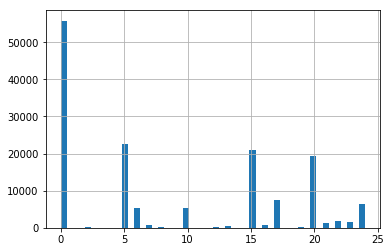

In [240]:
% matplotlib inline
pd.Series(agent_actions_train).hist(bins=50)

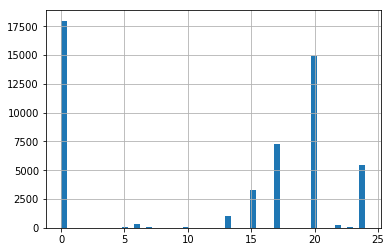

In [241]:
% matplotlib inline
pd.Series(agent_actions).hist(bins=50)

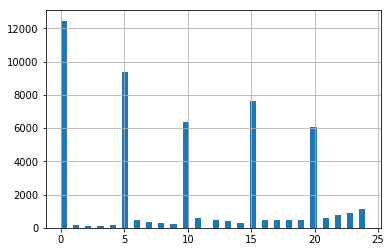

In [179]:
% matplotlib inline
pd.Series(phys_actions).hist(bins=50)

In [221]:
steps, losses = zip(*loss_hist)

In [222]:
steps, losses = list(steps), list(losses)

In [223]:
from matplotlib import pyplot as plt

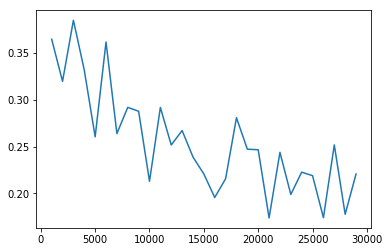

In [224]:
plt.plot(steps, losses)

In [225]:
_, phy_qs, agent_qs = zip(*mean_q_hist)
phy_qs, agent_qs = list(phy_qs),list(agent_qs)

([<matplotlib.lines.Line2D at 0x1259c9390>],
 [<matplotlib.lines.Line2D at 0x1259c9550>])

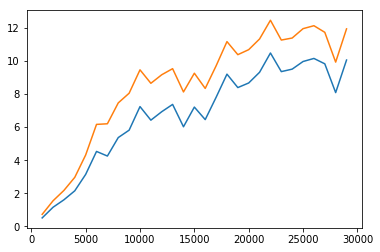

In [226]:
plt.plot(steps, phy_qs), plt.plot(steps, agent_qs)

In [242]:
pickle.dump(agent_actions_train, open('r4/agent_actions_train.pkl', 'wb'))
pickle.dump(agent_q_train, open('r4/agent_mean_q_train.pkl', 'wb'))
pickle.dump(phys_actions_train, open('r4/phy_actions_train.pkl', 'wb'))
pickle.dump(phys_q_train, open('r4/phy_mean_q_train.pkl', 'wb'))

In [243]:
pickle.dump(agent_actions, open('r4/agent_actions_test.pkl', 'wb'))
pickle.dump(agent_q, open('r4/agent_mean_q_test.pkl', 'wb'))
pickle.dump(phys_actions, open('r4/phy_actions_test.pkl', 'wb'))
pickle.dump(phys_q, open('r4/phy_mean_q_test.pkl', 'wb'))